In [18]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

%matplotlib inline

### Arms

In [3]:
class BernoulliArm():
    def __init__(self, p):
        self.p = p

    def draw(self):
        if np.random.rand() > self.p:
            return 0.0
        else:
            return 1.0

### Algorithms

In [463]:
class EpsilonGreedy():
    def __init__(self, epsilon, counts, values, annealing=False):
        self.epsilon = epsilon
        self.counts = counts
        self.values = values
        self.annealing = annealing

    def initialize(self, n_arms):
        self.counts, self.values = [0]*n_arms, [0]*n_arms

    def select_arm(self):
        if self.annealing:
            t = sum(self.counts) + 1
            epsilon = 1 / np.log(t + 0.0000001)
            
        if np.random.rand() > self.epsilon:
            return np.argmax(self.values)
        else:
            return np.random.randint(len(self.values))

    def update(self, chosen_arm, reward):
        self.counts[chosen_arm] = self.counts[chosen_arm] + 1
        n = self.counts[chosen_arm]

        value = self.values[chosen_arm]
        # Weighted average
        new_value = ((n - 1) / n) * value + (1 / n) * reward
        self.values[chosen_arm] = new_value

In [464]:
def categorical_draw(probs):
    z = np.random.rand()
    cum_prob = 0.0
    for i in range(len(probs)):
        prob = probs[i]
        cum_prob += prob
        if cum_prob > z:
            return i

    return len(probs) - 1

class Softmax:
    def __init__(self, temperature, counts, values, annealing=False):
        self.temperature = temperature
        self.counts = counts
        self.values = values
        self.annealing = annealing

    def initialize(self, n_arms):
        self.counts, self.values = [0]*n_arms, np.zeros(n_arms)

    def select_arm(self):
        if self.annealing:
            t = sum(self.counts) + 1
            temperature = 1 / np.log(t + 0.0000001)

        z = np.exp(self.values / self.temperature).sum()
        probs = np.exp(self.values / self.temperature) / z
        return categorical_draw(probs)

    def update(self, chosen_arm, reward):
        self.counts[chosen_arm] += 1
        n = self.counts[chosen_arm]

        value = self.values[chosen_arm]
        new_value = ((n - 1) / n) * value + (1 / n) * reward
        self.values[chosen_arm] = new_value

UCB1 algorithm, unlike its siblings, makes a couple of assumptions that you may need to be cautious about. Foremost of these is the assumption that the maximum possible reward has value 1. If that’s not true in your setting, you need to rescale all of your rewards to lie between 0 and 1 before using the UCB1 algorithm we present below.

The UCB algorithm is using this line to insure that it has played every single arm available to it at least once. This is UCB’s clever trick for insuring that it doesn’t have a total cold start before it starts to apply its confidence-based decision rule. It’s important to keep this initialization step in mind when you consider deploying UCB1: if you will only let the algorithm run for a small number of plays (say M) and you have many arms to explore (say N), it’s possible that UCB1 will just try every single arm in succession and not even make it to the end.

In [471]:
class UCB1():
    def __init__(self, counts, values):
        self.counts = counts
        self.values = values
        return

    def initialize(self, n_arms):
        self.counts, self.values = [0]*n_arms, np.zeros(n_arms)

    def select_arm(self):
        n_arms = len(self.counts)
        for arm in range(n_arms):
            if self.counts[arm] == 0:
                return arm

        ucb_values = [0]*n_arms
        total_counts = sum(self.counts)
        for arm in range(n_arms):
            bonus = np.sqrt((2 * np.log(total_counts)) / self.counts[arm])
            ucb_values[arm] = self.values[arm] + bonus
        return np.argmax(ucb_values)

    def update(self, chosen_arm, reward):
        self.counts[chosen_arm] += 1
        n = self.counts[chosen_arm]

        value = self.values[chosen_arm]
        new_value = ((n - 1) / n) * value + (1 / n) * reward
        self.values[chosen_arm] = new_value

### Testing

In [465]:
def test_algorithm(algo, arms, horizon):
    arms_best = []
    probability_select = {k:[0] for k in range(len(arms))}
    
    cumulative_rewards = []
    
    algo.initialize(len(arms))

    for t in range(horizon):
        chosen_arm = algo.select_arm()
        reward = arms[algo.select_arm()].draw()

        if t == 0:
            cumulative_rewards.append(reward)
        else:
            cumulative_rewards.append(cumulative_rewards[-1] + reward)
        
        # pure exploitation
        # arms_best.append(np.argmax(algo.values))
        
        # What algorithms gives
        #print(algo.values)
        arms_best.append(chosen_arm)

        algo.update(chosen_arm, reward)
  
    return np.asarray(cumulative_rewards), arms_best

Best arm is 4
Arms [0.1, 0.1, 0.1, 0.1, 0.9]
Epsilon 0.1
Epsilon 0.3
Epsilon 0.5


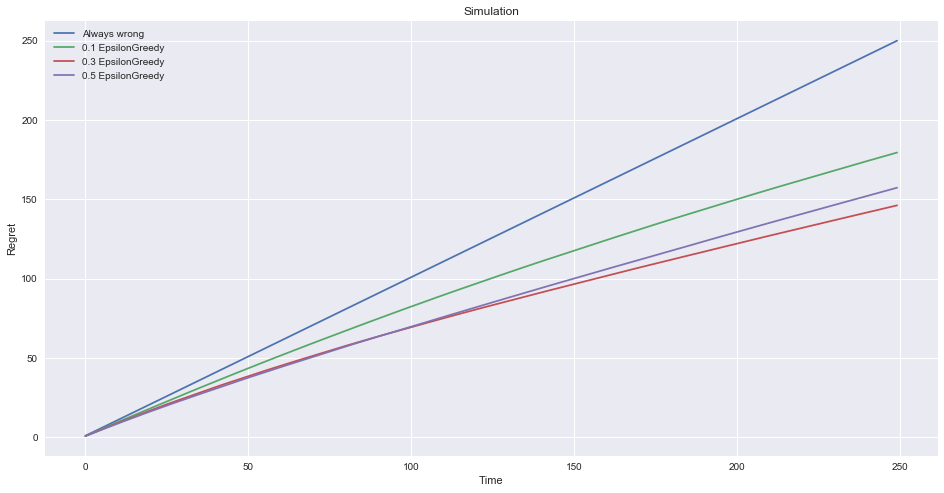

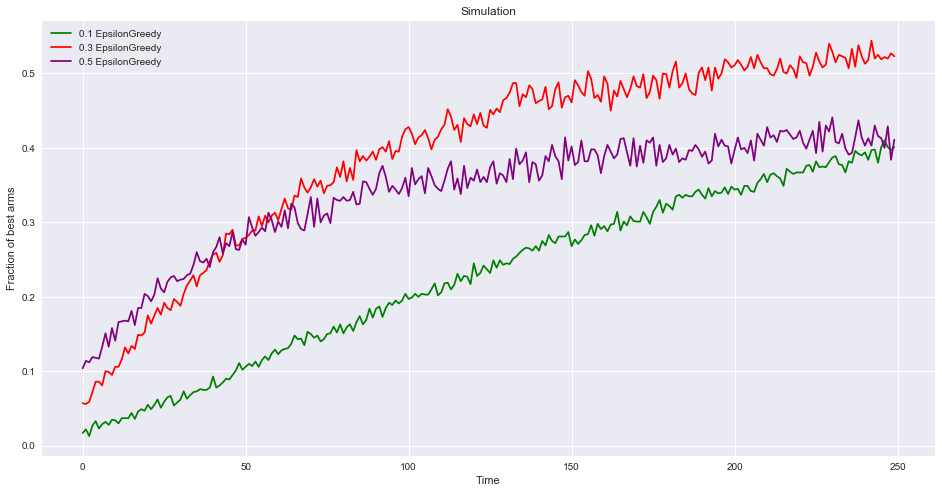

In [466]:
n_iter = 1000
horizon = 250
means = [0.1, 0.1, 0.1, 0.1, 0.9]
regret = {}
fraction_best_arm = {}

n_arms = len(means)
arms = list(map(lambda mu: BernoulliArm(mu), means))

best_arm = np.argmax(means)
print("Best arm is", best_arm)
print("Arms", means)

epsilons = [0.1, 0.3, 0.5]

for epsilon in epsilons:
    print("Epsilon", epsilon)
    algo = EpsilonGreedy(epsilon, [], [], annealing=False)
    algo.initialize(n_arms)
    
    results = np.asarray([test_algorithm(algo, arms, horizon)
                          for _ in range(n_iter)])
            
    rewards = np.concatenate(results[:, 0]).reshape(n_iter, horizon).mean(axis=0)
    
    fraction_best_arm[epsilon] = np.asarray(results[:, 1] == best_arm).mean(axis=0)
    
    regret[epsilon] = np.cumsum(horizon*[1]) - rewards

    
plt.figure(figsize=(16, 8))
plt.plot(range(horizon), np.cumsum(horizon*[1]), label='Always wrong')

for epsilon in epsilons:
    plt.plot(range(horizon), 
             regret[epsilon], 
             label='{} EpsilonGreedy'.format(epsilon))
plt.title("Simulation")
plt.xlabel("Time")
plt.ylabel("Regret")
plt.legend()

plt.figure(figsize=(16, 8))

colors = ["green", "red", "purple"]
for i, epsilon in enumerate(epsilons):
    plt.plot(range(horizon), 
             fraction_best_arm[epsilon], 
             label='{} EpsilonGreedy'.format(epsilon),
             color=colors[i])
plt.title("Simulation")
plt.xlabel("Time")
plt.ylabel("Fraction of best arms")
plt.legend()

Best arm is 4
Arms [0.1, 0.1, 0.1, 0.1, 0.12]
Epsilon 0.1
Epsilon 0.3
Epsilon 0.5


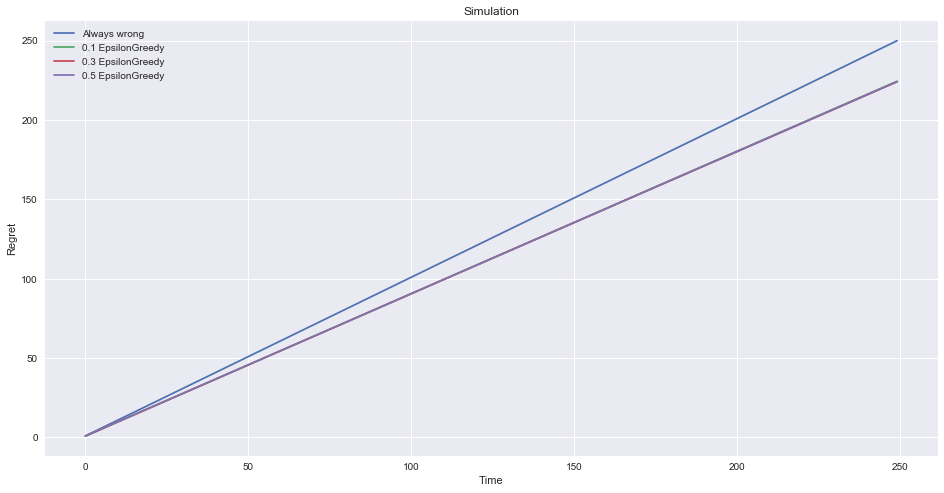

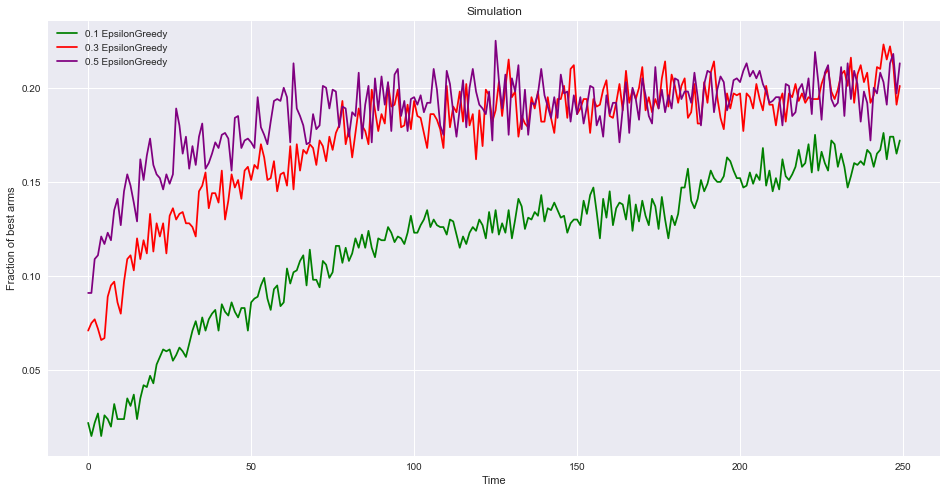

In [467]:
n_iter = 1000
horizon = 250
means = [0.1, 0.1, 0.1, 0.1, 0.12]
regret = {}
fraction_best_arm = {}

n_arms = len(means)
arms = list(map(lambda mu: BernoulliArm(mu), means))

best_arm = np.argmax(means)
print("Best arm is", best_arm)
print("Arms", means)

epsilons = [0.1, 0.3, 0.5]

for epsilon in epsilons:
    print("Epsilon", epsilon)
    algo = EpsilonGreedy(epsilon, [], [], annealing=True)
    algo.initialize(n_arms)
    
    results = np.asarray([test_algorithm(algo, arms, horizon)
                          for _ in range(n_iter)])
            
    rewards = np.concatenate(results[:, 0]).reshape(n_iter, horizon).mean(axis=0)
    
    fraction_best_arm[epsilon] = np.asarray(results[:, 1] == best_arm).mean(axis=0)
    
    regret[epsilon] = np.cumsum(horizon*[1]) - rewards

    
plt.figure(figsize=(16, 8))
plt.plot(range(horizon), np.cumsum(horizon*[1]), label='Always wrong')

for epsilon in epsilons:
    plt.plot(range(horizon), 
             regret[epsilon], 
             label='{} EpsilonGreedy'.format(epsilon))
plt.title("Simulation")
plt.xlabel("Time")
plt.ylabel("Regret")
plt.legend()

plt.figure(figsize=(16, 8))

colors = ["green", "red", "purple"]
for i, epsilon in enumerate(epsilons):
    plt.plot(range(horizon), 
             fraction_best_arm[epsilon], 
             label='{} EpsilonGreedy'.format(epsilon),
             color=colors[i])
plt.title("Simulation")
plt.xlabel("Time")
plt.ylabel("Fraction of best arms")
plt.legend()

Best arm is 4
Arms [0.1, 0.1, 0.1, 0.1, 0.9]
Temperature 0.1
Temperature 0.3
Temperature 0.5


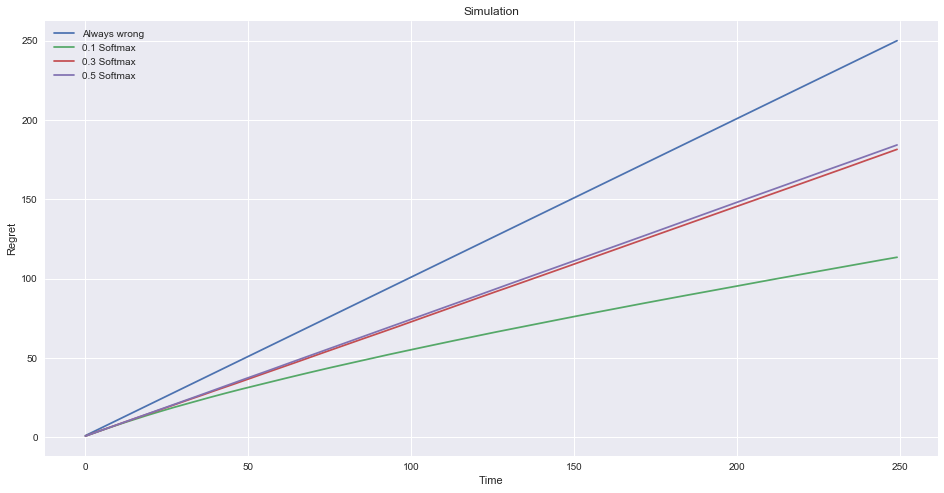

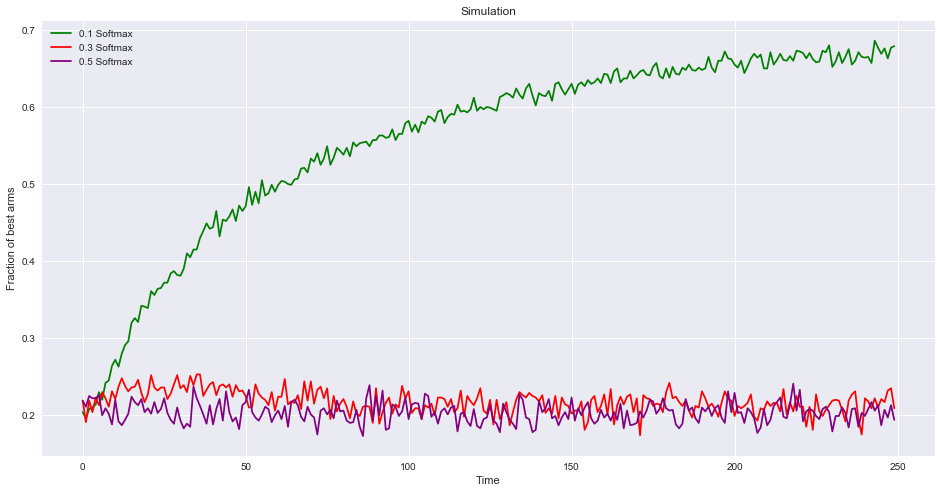

In [468]:
n_iter = 1000
horizon = 250
means = [0.1, 0.1, 0.1, 0.1, 0.9]
regret = {}
fraction_best_arm = {}

n_arms = len(means)
arms = list(map(lambda mu: BernoulliArm(mu), means))

best_arm = np.argmax(means)
print("Best arm is", best_arm)
print("Arms", means)

temperatures = [0.1, 0.3, 0.5]

for temperature in temperatures:
    print("Temperature", temperature)
    algo = Softmax(temperature, [], [], annealing=False)
    algo.initialize(n_arms)
    
    results = np.asarray([test_algorithm(algo, arms, horizon)
                          for _ in range(n_iter)])
            
    rewards = np.concatenate(results[:, 0]).reshape(n_iter, horizon).mean(axis=0)
    
    fraction_best_arm[temperature] = np.asarray(results[:, 1] == best_arm).mean(axis=0)
    
    regret[temperature] = np.cumsum(horizon*[1]) - rewards

    
plt.figure(figsize=(16, 8))
plt.plot(range(horizon), np.cumsum(horizon*[1]), label='Always wrong')

for temperature in temperatures:
    plt.plot(range(horizon), 
             regret[temperature], 
             label='{} Softmax'.format(temperature))
plt.title("Simulation")
plt.xlabel("Time")
plt.ylabel("Regret")
plt.legend()

plt.figure(figsize=(16, 8))

colors = ["green", "red", "purple"]
for i, temperature in enumerate(temperatures):
    plt.plot(range(horizon), 
             fraction_best_arm[temperature], 
             label='{} Softmax'.format(temperature),
             color=colors[i])
plt.title("Simulation")
plt.xlabel("Time")
plt.ylabel("Fraction of best arms")
plt.legend()

Best arm is 4
Arms [0.1, 0.1, 0.1, 0.1, 0.12]
Temperature 0.1
Temperature 0.3
Temperature 0.5


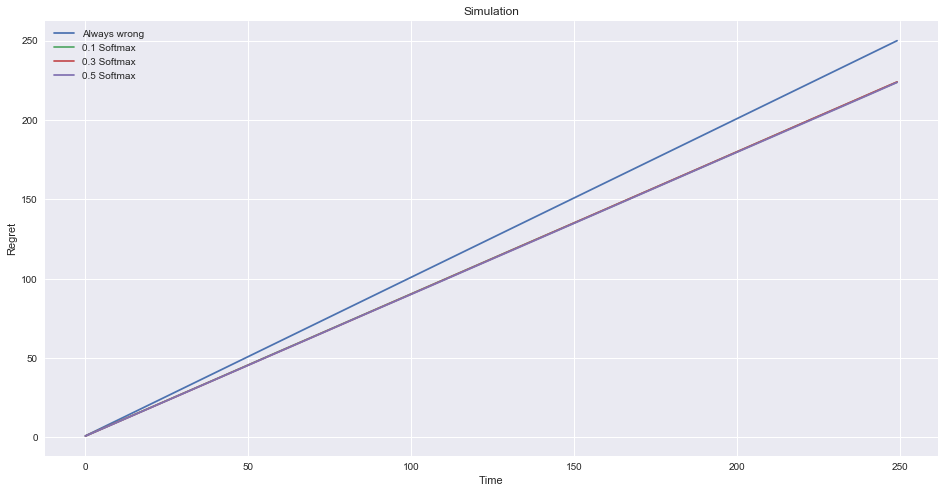

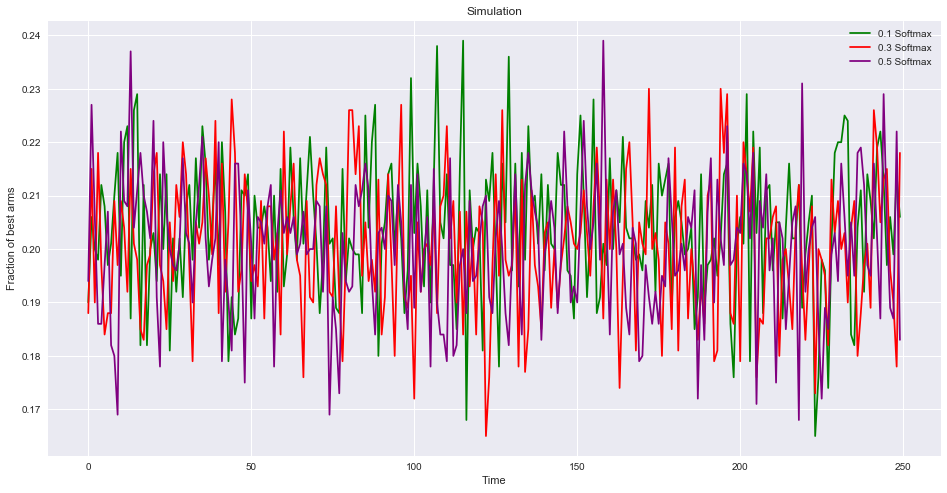

In [469]:
n_iter = 1000
horizon = 250
means = [0.1, 0.1, 0.1, 0.1, 0.12]
regret = {}
fraction_best_arm = {}

n_arms = len(means)
arms = list(map(lambda mu: BernoulliArm(mu), means))

best_arm = np.argmax(means)
print("Best arm is", best_arm)
print("Arms", means)

temperatures = [0.1, 0.3, 0.5]

for temperature in temperatures:
    print("Temperature", temperature)
    algo = Softmax(temperature, [], [], annealing=True)
    algo.initialize(n_arms)
    
    results = np.asarray([test_algorithm(algo, arms, horizon)
                          for _ in range(n_iter)])
            
    rewards = np.concatenate(results[:, 0]).reshape(n_iter, horizon).mean(axis=0)
    
    fraction_best_arm[temperature] = np.asarray(results[:, 1] == best_arm).mean(axis=0)
    
    regret[temperature] = np.cumsum(horizon*[1]) - rewards

    
plt.figure(figsize=(16, 8))
plt.plot(range(horizon), np.cumsum(horizon*[1]), label='Always wrong')

for temperature in temperatures:
    plt.plot(range(horizon), 
             regret[temperature], 
             label='{} Softmax'.format(temperature))
plt.title("Simulation")
plt.xlabel("Time")
plt.ylabel("Regret")
plt.legend()

plt.figure(figsize=(16, 8))

colors = ["green", "red", "purple"]
for i, temperature in enumerate(temperatures):
    plt.plot(range(horizon), 
             fraction_best_arm[temperature], 
             label='{} Softmax'.format(temperature),
             color=colors[i])
plt.title("Simulation")
plt.xlabel("Time")
plt.ylabel("Fraction of best arms")
plt.legend()

Best arm is 4
Arms [0.1, 0.1, 0.1, 0.1, 0.4]


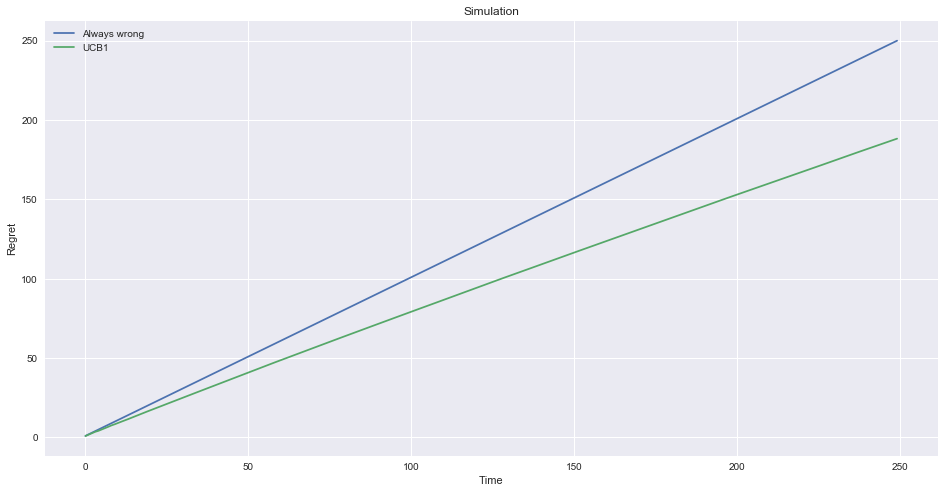

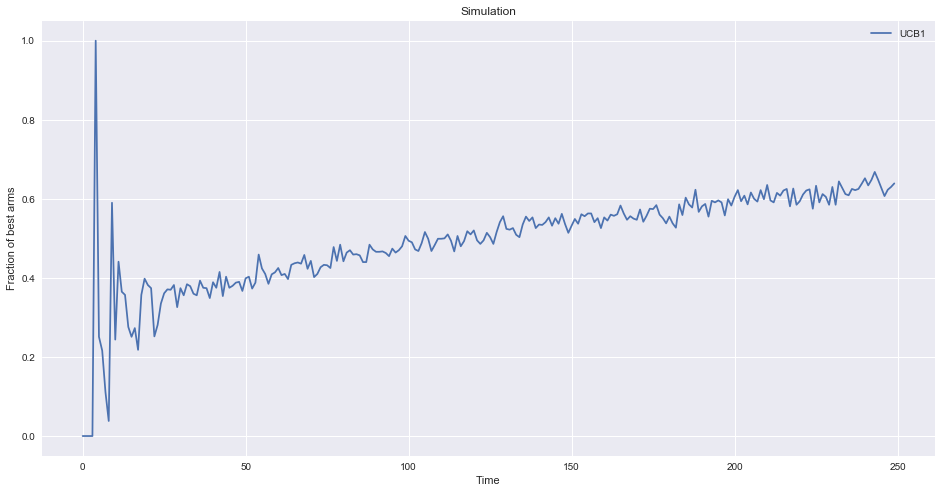

In [481]:
n_iter = 1000
horizon = 250
means = [0.1, 0.1, 0.1, 0.1, 0.4]
regret = {}
fraction_best_arm = {}

n_arms = len(means)
arms = list(map(lambda mu: BernoulliArm(mu), means))

best_arm = np.argmax(means)
print("Best arm is", best_arm)
print("Arms", means)

algo = UCB1([], [])
algo.initialize(n_arms)

results = np.asarray([test_algorithm(algo, arms, horizon)
                      for _ in range(n_iter)])

rewards = np.concatenate(results[:, 0]).reshape(n_iter, horizon).mean(axis=0)

fraction_best_arm = np.asarray(results[:, 1] == best_arm).mean(axis=0)

regret = np.cumsum(horizon*[1]) - rewards

    
plt.figure(figsize=(16, 8))
plt.plot(range(horizon), np.cumsum(horizon*[1]), label='Always wrong')

plt.plot(range(horizon), 
         regret, 
         label='UCB1')
plt.title("Simulation")
plt.xlabel("Time")
plt.ylabel("Regret")
plt.legend()

plt.figure(figsize=(16, 8))

plt.plot(range(horizon), 
         fraction_best_arm, 
         label='UCB1')
plt.title("Simulation")
plt.xlabel("Time")
plt.ylabel("Fraction of best arms")
plt.legend()

Best arm is 2
Arms [0.1, 0.3, 0.8, 0.2, 0.6]
Temperature 0.1
Epsilon 0.3


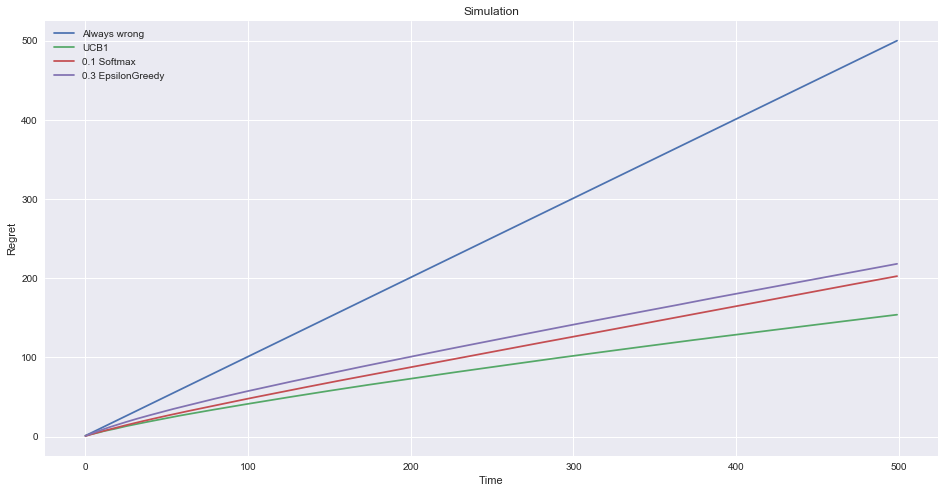

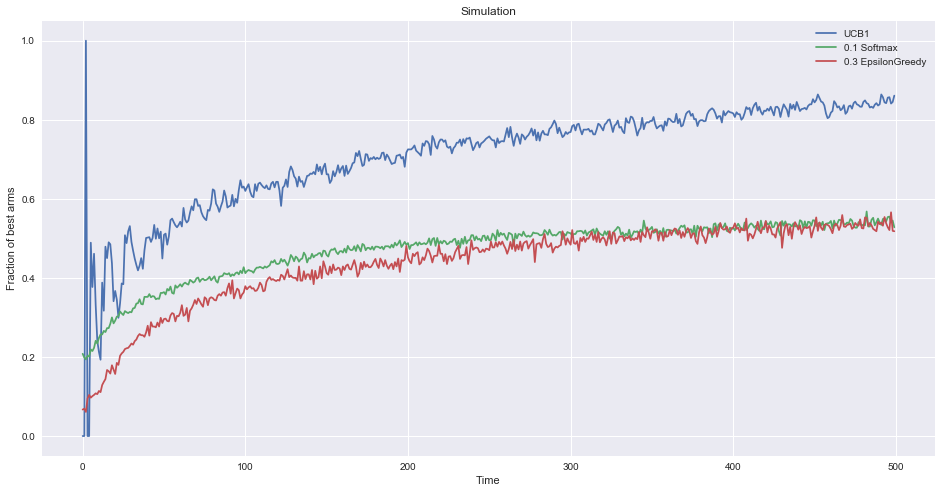

In [488]:
n_iter = 1000
horizon = 500
means = [0.1, 0.3, 0.8, 0.2, 0.6]
regret = {}
fraction_best_arm = {}

n_arms = len(means)
arms = list(map(lambda mu: BernoulliArm(mu), means))

best_arm = np.argmax(means)
print("Best arm is", best_arm)
print("Arms", means)

algo = UCB1([], [])
algo.initialize(n_arms)

results = np.asarray([test_algorithm(algo, arms, horizon)
                      for _ in range(n_iter)])

rewards = np.concatenate(results[:, 0]).reshape(n_iter, horizon).mean(axis=0)

fraction_best_arm_ucb = np.asarray(results[:, 1] == best_arm).mean(axis=0)

regret_ucb = np.cumsum(horizon*[1]) - rewards

temperature = 0.1

print("Temperature", temperature)
algo = Softmax(temperature, [], [], annealing=True)
algo.initialize(n_arms)

results = np.asarray([test_algorithm(algo, arms, horizon)
                      for _ in range(n_iter)])

rewards = np.concatenate(results[:, 0]).reshape(n_iter, horizon).mean(axis=0)

fraction_best_arm_softmax = np.asarray(results[:, 1] == best_arm).mean(axis=0)

regret_softmax = np.cumsum(horizon*[1]) - rewards

epsilon = 0.3

print("Epsilon", epsilon)
algo = EpsilonGreedy(epsilon, [], [], annealing=True)
algo.initialize(n_arms)

results = np.asarray([test_algorithm(algo, arms, horizon)
                      for _ in range(n_iter)])

rewards = np.concatenate(results[:, 0]).reshape(n_iter, horizon).mean(axis=0)

fraction_best_arm_epsilon = np.asarray(results[:, 1] == best_arm).mean(axis=0)

regret_epsilon = np.cumsum(horizon*[1]) - rewards

    
plt.figure(figsize=(16, 8))
plt.plot(range(horizon), np.cumsum(horizon*[1]), label='Always wrong')

plt.plot(range(horizon), 
         regret_ucb, 
         label='UCB1')

plt.plot(range(horizon), 
         regret_softmax, 
         label='{} Softmax'.format(temperature))

plt.plot(range(horizon), 
         regret_epsilon, 
         label='{} EpsilonGreedy'.format(epsilon))

plt.title("Simulation")
plt.xlabel("Time")
plt.ylabel("Regret")
plt.legend()

plt.figure(figsize=(16, 8))

plt.plot(range(horizon), 
         fraction_best_arm_ucb, 
         label='UCB1')

plt.plot(range(horizon), 
         fraction_best_arm_softmax, 
         label='{} Softmax'.format(temperature))

plt.plot(range(horizon), 
         fraction_best_arm_epsilon, 
         label='{} EpsilonGreedy'.format(epsilon))

plt.title("Simulation")
plt.xlabel("Time")
plt.ylabel("Fraction of best arms")
plt.legend()